In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from pyearth import Earth
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from patsy import dmatrix
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS

#Libraries for visualizing trees
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image

#import pydotplus
import time as tm

import itertools as it

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

# Data quality check / cleaning / preparation¶

### Cleaning - Training Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



# Create Credit Ratings based on Investopedia Values
train['Credit_Rating'] = 0
train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Good',
                          np.random.uniform(670, 730, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Standard',
                          np.random.uniform(580, 670, size=len(train)),
                          train['Credit_Rating'])

train['Credit_Rating'] = np.where(train['Credit_Score'] == 'Poor',
                          np.random.uniform(0, 580, size=len(train)),
                          train['Credit_Rating'])



# Drop irrelevant columns
columns_to_drop = ['Customer_ID', 'ID','Month', 'Name', 'SSN', 'Interest_Rate','Occupation',
                    'Type_of_Loan', 'Delay_from_due_date', 'Payment_Behaviour', 'Credit_History_Age', 'Credit_Score']

train.drop(columns_to_drop, axis=1, inplace=True)



# Removing invalid characters from columns
mix_type_num_col = ['Age', 'Annual_Income', 
                    'Num_of_Delayed_Payment','Changed_Credit_Limit',
                    'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_of_Loan']

def set_numeric_columns(features,df=None):

    df[features]=df[features].apply(lambda x: x.replace('_','',regex=True) )
    df[features]=df[features].apply(lambda x: x.str.strip())
    df[features]=df[features].apply(lambda x: x.replace('',np.nan))
    df[features[1:]]=df[features[1:]].astype('float32')
    df[features[0]]=df[features[0]].astype('int32')

set_numeric_columns(mix_type_num_col,df=train)

In [4]:
train = train.dropna()

train = train.loc[train.Credit_Mix != "_"]
train = train.loc[train.Payment_of_Min_Amount != "NM"]

train_dummies = pd.get_dummies(train)

In [5]:
y = train_dummies.Credit_Rating
X = train_dummies.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

# Base Model

In [6]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [7]:
pred = model.predict(X_test)

In [8]:
print("The RMSE of the Base Model is", np.sqrt(mean_squared_error(y_test, pred)))

The RMSE of the Base Model is 207.9851910025165


# Visualization

In [9]:
# remove outliers

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
def remove_outliers(df, columns, threshold=3):
    print(columns)
    outliers_indices = []
    for column_name in columns:
        # Calculate the Z-scores for the specified column
        z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
        # Identify outliers based on the threshold
        outliers_indices.extend(z_scores[z_scores > threshold].index)
    
    df_no_outliers = df.drop(outliers_indices)
    return df_no_outliers

train = remove_outliers(train, train.select_dtypes(include = numerics).columns.tolist(), threshold = 1)


['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Rating']


###  Base Model without outliers

In [10]:
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

In [11]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X, y)

DecisionTreeRegressor(random_state=1)

In [12]:
pred = model.predict(X_test)

In [13]:
print("The RMSE of the Base Model is", np.sqrt(mean_squared_error(y_test, pred)))

The RMSE of the Base Model is 88.84993604344415


### distribution of the response variable

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

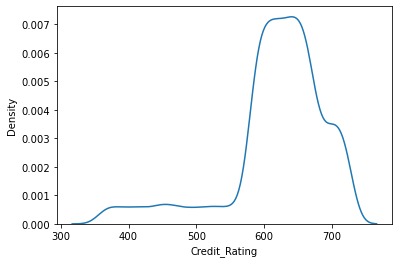

In [14]:
sns.kdeplot(train_final.Credit_Rating)

### distribution of each predictor

#### continuous

In [15]:
train_dummies.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Rating,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
6,23,19114.119141,1824.843333,3,4,4.0,8.0,11.27,4.0,809.979980,22.537593,49.574949,178.344070,244.565323,680.030192,0,1,0,1,0
7,23,19114.119141,1824.843333,3,4,4.0,6.0,11.27,4.0,809.979980,23.933795,49.574949,24.785217,358.124176,626.816172,0,1,0,1,0
8,28,34847.839844,3037.986667,2,4,1.0,4.0,5.42,2.0,605.030029,24.464031,18.816215,104.291824,470.690613,581.543334,0,1,0,1,0
9,28,34847.839844,3037.986667,2,4,1.0,1.0,7.42,2.0,605.030029,38.550848,18.816215,40.391239,484.591217,693.047314,0,1,0,1,0
12,28,34847.839844,3037.986667,2,4,1.0,1.0,6.42,2.0,605.030029,34.977895,18.816215,130.115417,444.867035,699.213030,0,1,0,1,0


In [16]:
train_final.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Rating,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
12,28,34847.839844,3037.986667,2,4,1.0,1.0,6.42,2.0,605.030029,34.977895,18.816215,130.115417,444.867035,699.213030,0,1,0,1,0
13,28,34847.839844,3037.986667,2,4,1.0,0.0,5.42,2.0,605.030029,33.381010,18.816215,43.477192,481.505249,722.092317,0,1,0,1,0
15,28,34847.839844,3037.986667,2,4,1.0,4.0,5.42,2.0,605.030029,32.933856,18.816215,218.904343,356.078094,677.615964,0,1,0,1,0
43,31,73928.460938,5988.705000,4,5,0.0,7.0,10.14,2.0,548.200012,30.201658,0.000000,618.202393,270.668121,692.672589,0,1,0,1,0
81,40,33751.269531,2948.605833,5,5,3.0,20.0,11.00,4.0,1328.930054,30.908081,65.008174,70.131081,399.721344,583.103568,0,0,1,0,1


<AxesSubplot:xlabel='Age', ylabel='Density'>

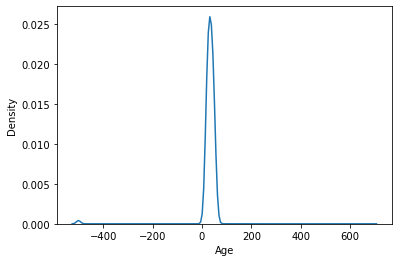

In [17]:
sns.kdeplot(train_final.Age)

<AxesSubplot:xlabel='Annual_Income', ylabel='Density'>

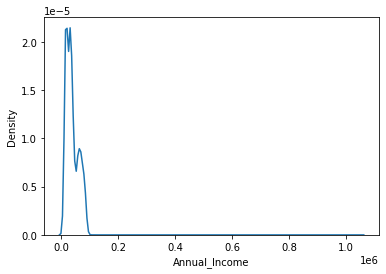

In [18]:
sns.kdeplot(train_final.Annual_Income)

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Density'>

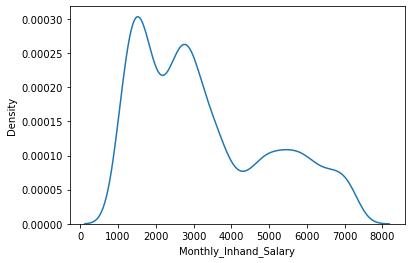

In [19]:
sns.kdeplot(train_final.Monthly_Inhand_Salary)

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Density'>

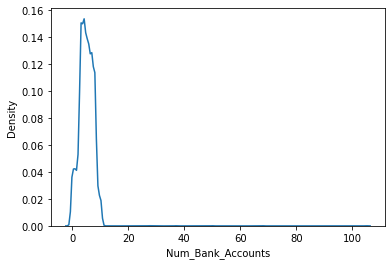

In [20]:
sns.kdeplot(train_final.Num_Bank_Accounts)

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Density'>

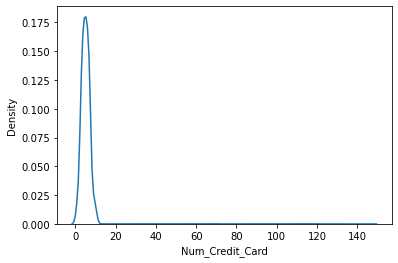

In [21]:
sns.kdeplot(train_final.Num_Credit_Card)

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Density'>

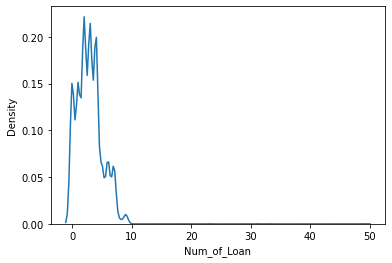

In [22]:
sns.kdeplot(train_final.Num_of_Loan)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Density'>

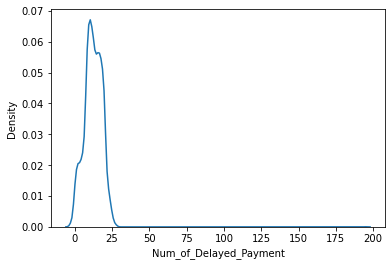

In [23]:
sns.kdeplot(train_final.Num_of_Delayed_Payment)

<AxesSubplot:xlabel='Changed_Credit_Limit', ylabel='Density'>

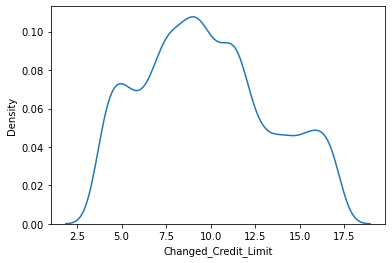

In [24]:
sns.kdeplot(train_final.Changed_Credit_Limit)

<AxesSubplot:xlabel='Num_Credit_Inquiries', ylabel='Density'>

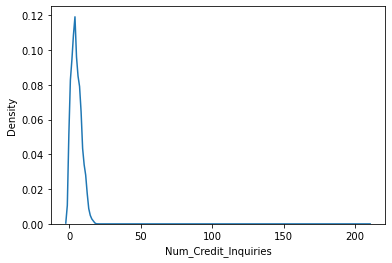

In [25]:
sns.kdeplot(train_final.Num_Credit_Inquiries)

<AxesSubplot:xlabel='Outstanding_Debt', ylabel='Density'>

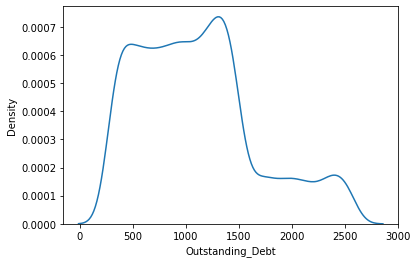

In [26]:
sns.kdeplot(train_final.Outstanding_Debt)

<AxesSubplot:xlabel='Credit_Utilization_Ratio', ylabel='Density'>

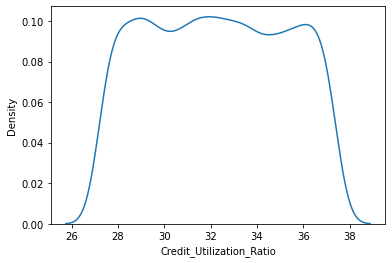

In [27]:
sns.kdeplot(train_final.Credit_Utilization_Ratio)

<AxesSubplot:xlabel='Total_EMI_per_month', ylabel='Density'>

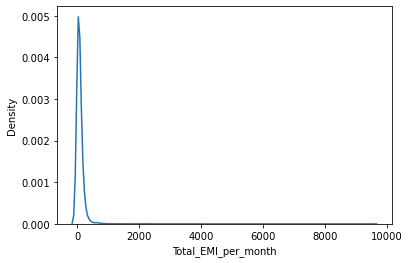

In [28]:
sns.kdeplot(train_final.Total_EMI_per_month)

<AxesSubplot:xlabel='Amount_invested_monthly', ylabel='Density'>

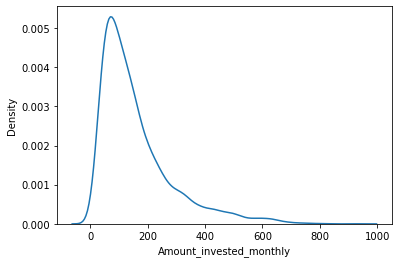

In [29]:
sns.kdeplot(train_final.Amount_invested_monthly)

<AxesSubplot:xlabel='Monthly_Balance', ylabel='Density'>

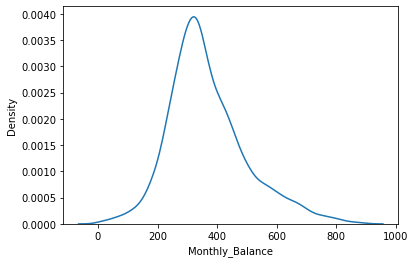

In [30]:
sns.kdeplot(train_final.Monthly_Balance)

<AxesSubplot:xlabel='Credit_Rating', ylabel='Density'>

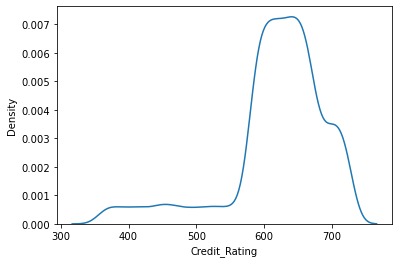

In [31]:
sns.kdeplot(train_final.Credit_Rating)

#### categorical

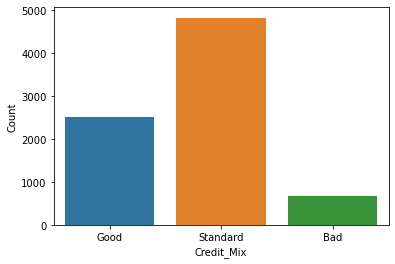

In [32]:
# Credit_Mix
sns.countplot(x='Credit_Mix', data = train)
plt.xlabel('Credit_Mix')
plt.ylabel('Count')

plt.show()

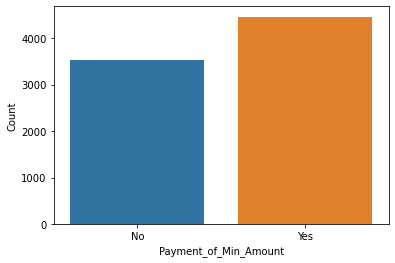

In [33]:
# Payment of Min Amount 
sns.countplot(x='Payment_of_Min_Amount', data = train)
plt.xlabel('Payment_of_Min_Amount')
plt.ylabel('Count')

plt.show()

# TRAIN DATASET IS CALLED train_final*******

In [34]:
train_final = pd.get_dummies(train)
y = train_final.Credit_Rating
X = train_final.drop(columns = 'Credit_Rating')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

X = X_train[X_train.columns]
y = y_train

## Bagging - Nicket

### grid search

In [35]:
n_samples = train.shape[0]
n_features = train.shape[1]

params = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [150,200,250],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=BaggingRegressor(n_jobs=-1, random_state=1), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeRegressor(random_state=1),
                                            LinearRegression()],
                         'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0],
                         'n_estimators': [150, 200, 250]},
             verbose=1)

In [36]:
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 250}


In [37]:
#Model with optimal parameters
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(RMSE)


62.94494827642976


### finer grid search 1

In [38]:
n_samples = train.shape[0]
n_features = train.shape[1]

finer_params1 = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [250, 300, 350],
          'max_samples': [1.0, 1.5],
          'max_features': [1.0, 1.5],
          'bootstrap': [True],
          'bootstrap_features': [True]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid_finer1 = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =finer_params1, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid_finer1.fit(X, y)

print('Best Parameters : ',bagging_regressor_grid_finer1.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 350}


In [39]:
#Model with optimal parameters
model_finer1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model_finer1.predict(X_test)))
print(RMSE)


62.94494827642976


### finer grid search 2

In [40]:
n_samples = train.shape[0]
n_features = train.shape[1]

finer_params2 = {'base_estimator': [DecisionTreeRegressor(random_state = 1),LinearRegression()],#Comparing bagging with a linear regression model as well
          'n_estimators': [250, 300, 350],
          'max_samples': [.75, 1.0, 1.25],
          'max_features': [.75, 1.0, 1.25],
          'bootstrap': [True],
          'bootstrap_features': [True]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid_finer2 = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), 
                                      param_grid =finer_params2, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid_finer2.fit(X_train, y_train)

print('Best Parameters : ',bagging_regressor_grid_finer1.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=1), 'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 350}


In [41]:
#Model with optimal parameters
model_finer2 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=300, random_state=1,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

#RMSE on test data
RMSE = np.sqrt(mean_squared_error(y_test, model_finer2.predict(X_test)))
print(RMSE)


62.924876932873474


## Random Forest - Kaylee

In [42]:
rmse = {}

for i in np.linspace(10, 500, 40,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,
                        n_jobs=-1, oob_score=True).fit(X, y)
    pred = model.predict(X_test)
    rmse[i] = np.sqrt(mean_squared_error(y_test, pred))

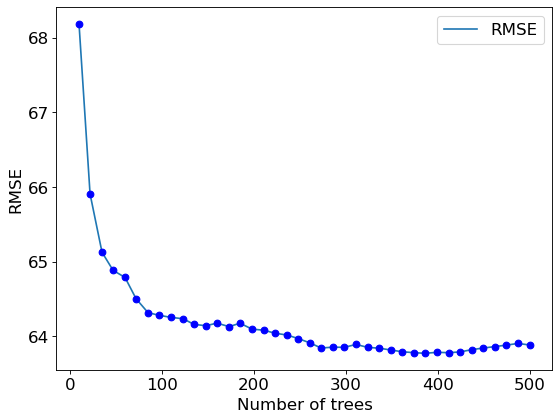

In [43]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(rmse.keys(),rmse.values(),label = 'RMSE')
plt.plot(rmse.keys(),rmse.values(),'o', color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

### course grid

In [44]:
# seems to slow down between 400 and 500

n_samples = train_final.shape[0]
n_features = train_final.shape[1]

params = {'max_depth': [12,15,18],
          'max_leaf_nodes':[1100,1200,1300],
          'max_features': list(range(1,20))}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestRegressor(random_state = 1, oob_score = True,
                                  verbose = False, n_estimators = 450,
                                  max_depth = pr[0],
                                  max_leaf_nodes = pr[1], 
                                  max_features = pr[2],
                                  n_jobs = -1).fit(X, y)
    oob_score[i] = model.oob_score_
    i=i+1
    

print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (18, 1100, 4)
Best score (R-squared) =  0.311985471800847


In [45]:
model_rf = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 18,
                                max_leaf_nodes = 1300,
                                max_features = 3,
                                n_jobs = -1)

model_rf.fit(X, y)

pred_rf = model_rf.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf)))

The RMSE on test data is 63.04955681868982


### finer grid 1

In [46]:
n_samples = train_final.shape[0]
n_features = train_final.shape[1]

params = {'max_depth': range(15, 25, 3),
          'max_leaf_nodes':range(1300, 1600, 100),
          'max_features': list(range(1,5))}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)

i=0
for pr in param_list:
    model = RandomForestRegressor(random_state = 1, oob_score = True,
                                  verbose = False, n_estimators = 450,
                                  max_depth = pr[0],
                                  max_leaf_nodes = pr[1], 
                                  max_features = pr[2],
                                  n_jobs = -1).fit(X, y)
    oob_score[i] = model.oob_score_
    i=i+1
    

print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (21, 1300, 2)
Best score (R-squared) =  0.31603000937970793


In [47]:
model_rf2 = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 21,
                                max_leaf_nodes = 1400,
                                max_features = 3,
                                n_jobs = -1)

model_rf2.fit(X, y)

pred_rf2 = model_rf2.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf2)))

The RMSE on test data is 62.845725877483


### finer grid 2

In [48]:
params = {'max_depth': range(15, 25, 3),
          'max_leaf_nodes':range(1300, 1600, 100),
          'max_features': list(range(1,5)),
          'bootstrap': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)


rf = RandomForestRegressor(n_estimators = 450, random_state = 1)


grid_search = GridSearchCV(rf, 
                           params, 
                           cv = cv, 
                           n_jobs = -1, 
                           verbose = 1,
                           scoring='neg_mean_absolute_error')


grid_search.fit(X_train, y_train)



print (grid_search.best_score_, grid_search.best_params_) 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
-45.05644762104609 {'bootstrap': False, 'max_depth': 24, 'max_features': 2, 'max_leaf_nodes': 1500}


In [49]:
model_rf_final = RandomForestRegressor(random_state = 1,
                                n_estimators = 450,
                                max_depth = 24,
                                max_leaf_nodes = 1500,
                                max_features = 2,
                                bootstrap = False,
                                n_jobs = -1)

model_rf_final.fit(X, y)

pred_rf_final = model_rf_final.predict(X_test)

print("The RMSE on test data is", np.sqrt(mean_squared_error(y_test, pred_rf_final)))

The RMSE on test data is 62.62198124153995


## MARS - Luca

## XG Boost - Ashley

In [50]:
import warnings
warnings.filterwarnings("ignore")

### course grid

In [51]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.5}
Optimal cross validation R-squared =  0.29267171580726226
Time taken =  8  minutes


In [52]:
means = optimal_params.cv_results_['mean_test_score']
stds = optimal_params.cv_results_['std_test_score']
params = optimal_params.cv_results_['params']

In [53]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

64.0918472388101

### visualization

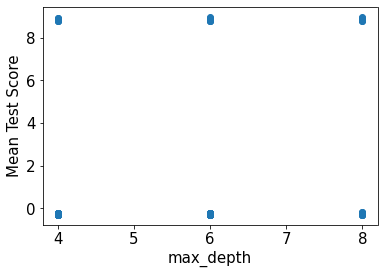

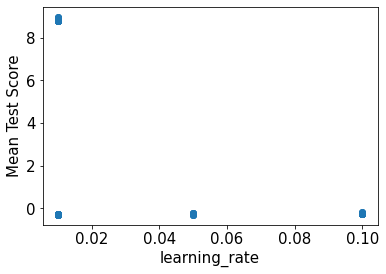

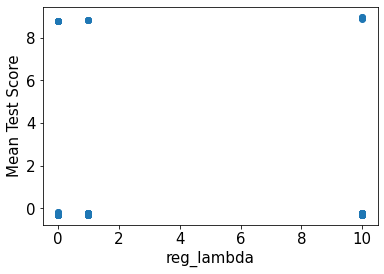

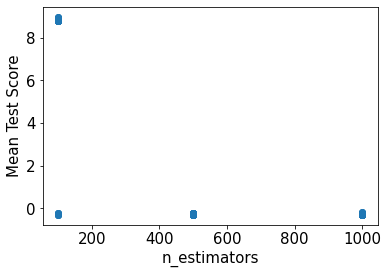

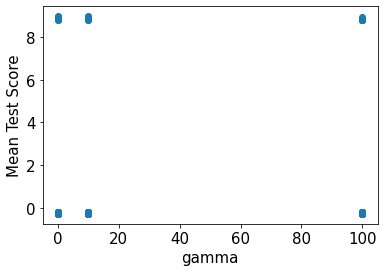

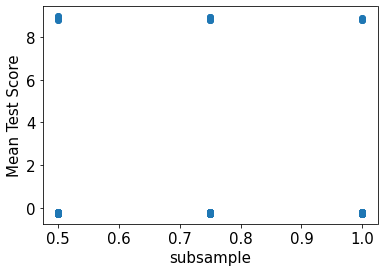

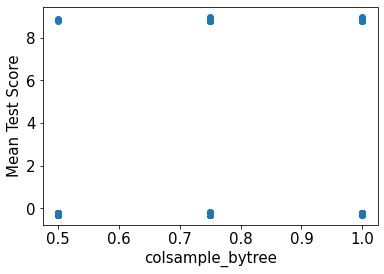

In [54]:
param_names = ['max_depth','learning_rate','reg_lambda','n_estimators','gamma','subsample','colsample_bytree']

for i in range(len(param_names)):
    values = []
    for j in range(len(params)):
        values.append(params[j][param_names[i]])    
    fig, ax = plt.subplots()
    ax.scatter(values, -means)
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Mean Test Score')    
    plt.show()

### finer grid 1

In [55]:
start_time = time.time()
param_grid = {'max_depth': [5,6,7],
              'learning_rate': [0.01,0.011],
               'reg_lambda':[0.4,1,1.5],
                'n_estimators':[1000, 2000, 3000],
                'gamma': [50,100],
                'subsample': [0.45,0.5,0.55],
                'colsample_bytree': [0.4,0.5]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,n_jobs=-1,cv=cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.55, 'reg_lambda': 1.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 0.4}
Optimal cross validation R-squared =  0.2780029407688911
Time taken =  5  minutes


In [56]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

64.09959695812192

### finer grid 2

In [57]:
start_time = time.time()
param_grid = {'max_depth': [7],
              'learning_rate': [0.01,0.0088],
               'reg_lambda':[0.4],
                'n_estimators':[1000,1500,1650],
                'gamma': [15,50],
                'subsample': [0.5,0.55],
                'colsample_bytree': [0.4]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,n_jobs=-1,cv=cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Optimal parameter values = {'subsample': 0.55, 'reg_lambda': 0.4, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.0088, 'gamma': 50, 'colsample_bytree': 0.4}
Optimal cross validation R-squared =  0.2772467683968043
Time taken =  1  minutes


In [58]:
## hopefully this gives the params below bc it gives the lowest rmse out of everything i've tried 

model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1650,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

np.sqrt(mean_squared_error(model.predict(X_test),y_test))

63.96081567872314

### change n_estimators

In [59]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1500,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=50,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [60]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

63.97577574154232

### change gamma

In [61]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=50,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [62]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

63.998499482310955

In [63]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=10,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [64]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.02253967410785

In [65]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.55,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [66]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

64.0245914125484

### change subsample

In [67]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.01,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [68]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

63.815152216570134

### change learning_rate

In [69]:
model = xgb.XGBRegressor(random_state=1,
                         subsample=0.5,
                         reg_lambda=0.4,
                         n_estimators=1700,
                         max_depth=7,
                         learning_rate=0.0088,
                         gamma=15,
                         colsample_bytree=0.4).fit(X_train,y_train)

In [70]:
np.sqrt(mean_squared_error(model.predict(X_test),y_test))

63.964307117269485

## Ensemble Model